In [1]:
from __future__ import print_function
import math
import numpy as np
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

x_train.shape =  (3000, 2)
y_train.shape =  (3000, 1)


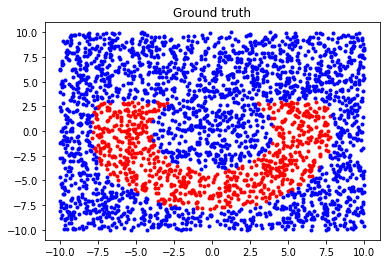

In [2]:
####################################################
## 2D FUNCTIONS - UNIT TEST

def create_dataset_2d_cos():    
    sz = 2000 # dataset size
    X1 = np.random.uniform(low=-10, high=10, size=sz)
    X2 = np.random.uniform(low=-10, high=10, size=sz)
    Y = np.ones((sz, 1))
    Y[X2 > 3.0 * np.cos(X1) - 0.5] = 0

    x_train = np.stack([X1, X2], axis = 1)
    y_train = np.copy(Y)
    return x_train, y_train, X1, X2, Y

def create_dataset_2d_half_circle():    
    sz = 3000 # dataset size
    X1 = np.random.uniform(low=-10, high=10, size=sz)
    X2 = np.random.uniform(low=-10, high=10, size=sz)
    Y = np.ones((sz, 1))
    Y[np.logical_or(np.logical_or(
        np.sqrt(X2**2 + X1**2) < 4,
        np.sqrt(X2**2 + X1**2) > 8),
        X2 > 3)] = 0

    x_train = np.stack([X1, X2], axis = 1)
    y_train = np.copy(Y)
    return x_train, y_train, X1, X2, Y

def plot_points_2d(X1, X2, Y, title, iter = None):
    mask0 = np.squeeze((Y - 0.5) > 0)
    mask1 = np.squeeze((Y - 0.5) < 0)
    plt.plot(X1[mask0], X2[mask0], 'r.')
    plt.plot(X1[mask1], X2[mask1], 'b.')
    plt.title(title)
    if iter is not None:
        plt.savefig('plots/learning %s %d.png' % (title, iter))
    else:
        plt.show()
        
        
x_train, y_train, X1, X2, Y = create_dataset_2d_half_circle()
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)

plot_points_2d(X1, X2, Y, "Ground truth")

In [3]:
# You should build your custom dataset as below.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels   
        
    def __getitem__(self, index):
        x = torch.from_numpy(self.inputs[index].astype(np.float32))
        y = torch.from_numpy(np.squeeze(self.labels[index]).astype(np.longlong))
        return x, y
        
    def __len__(self):        
        return self.labels.shape[0]

In [4]:
## pytorch sequntial model
        
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

def create_model():
    layers = [
        nn.Linear(2, 35),
        nn.ReLU(),
        nn.Linear(35, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 2),
        nn.Sigmoid(),
    ]

    model = nn.Sequential(*layers)
    return model

def fit(model, dataset, criterion, optimizer, n_epochs, batch_size, verbose=False):
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True)
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if verbose:
                # print statistics                
                if i % 100 == 99:    # print every 20 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    running_loss = 0.0
                    
                    # TODO: REMOVE
                    Y_pred = np.expand_dims(predict_dataset(model, dataset), axis=1)
                    plot_points_2d(X1, X2, Y_pred, "Prediceted")

def predict_dataset(model, dataset, batch_size=1):
    predicted_lst = []
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=False)    
    with torch.no_grad():
        for (inputs, _) in data_loader:
            predicted = predict(model, inputs)
            predicted_lst.append(predicted.numpy())
           
    predicted_lst = np.concatenate(predicted_lst, axis=0)
    return predicted_lst
    
def predict(model, inputs, batch_size=1):
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        return predicted
                    
def test(model, dataset, batch_size=1):
    correct = 0
    total = 0    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for (inputs, labels) in data_loader:
            predicted = predict(model, inputs, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the %d test data points: %d %%' % (
        dataset.__len__(),
        100 * correct / total))
    

[1,   100] loss: 0.450


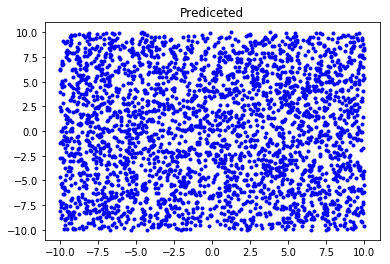

[1,   200] loss: 0.421


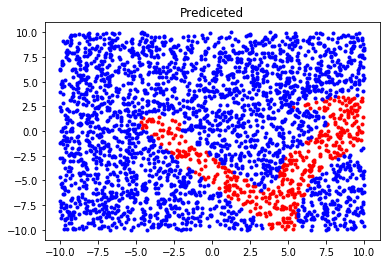

[1,   300] loss: 0.346


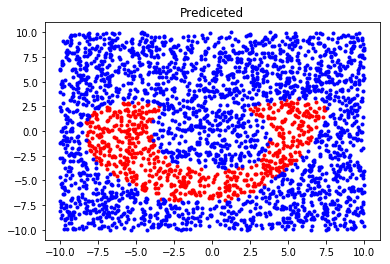

[2,   100] loss: 0.238


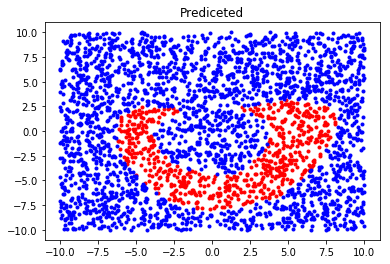

[2,   200] loss: 0.201


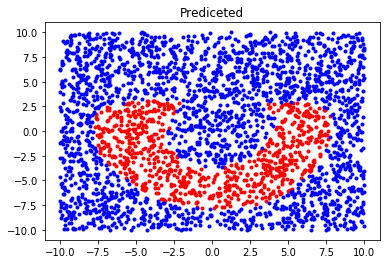

[2,   300] loss: 0.161


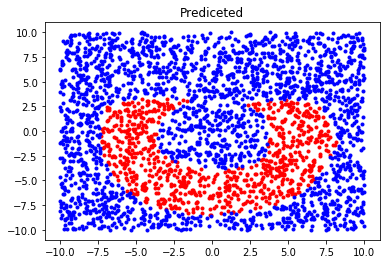

[3,   100] loss: 0.193


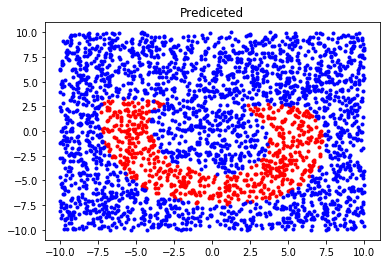

[3,   200] loss: 0.138


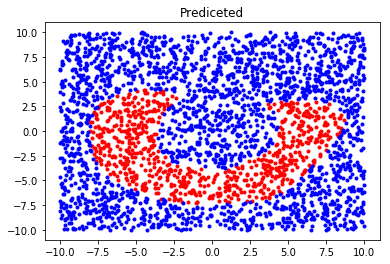

[3,   300] loss: 0.133


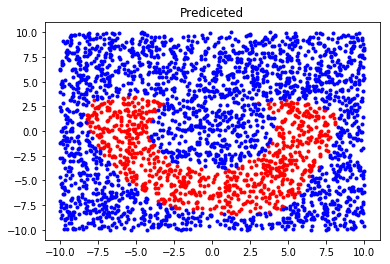

[4,   100] loss: 0.150


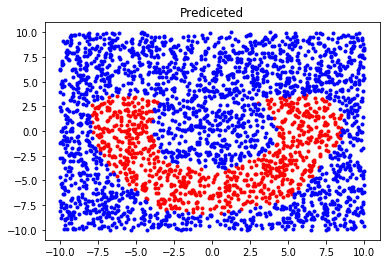

[4,   200] loss: 0.128


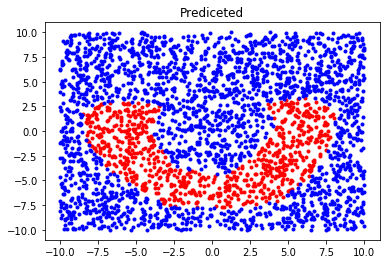

[4,   300] loss: 0.123


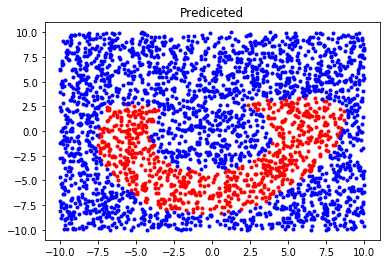

[5,   100] loss: 0.093


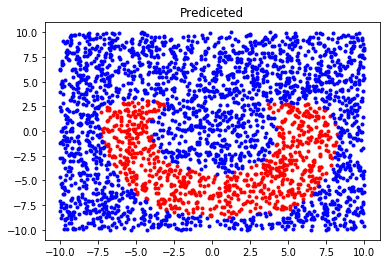

[5,   200] loss: 0.123


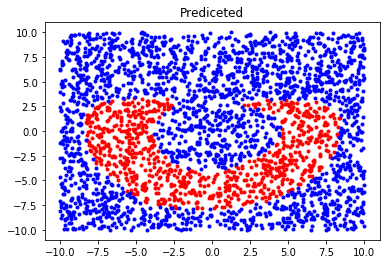

[5,   300] loss: 0.141


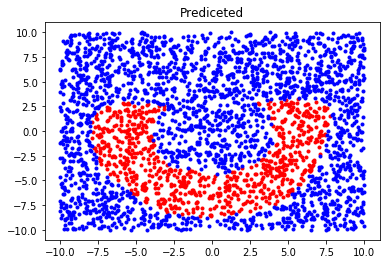

[6,   100] loss: 0.094


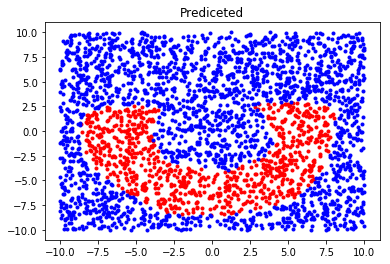

[6,   200] loss: 0.125


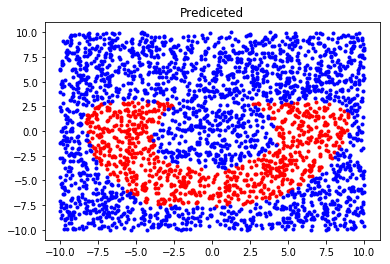

[6,   300] loss: 0.097


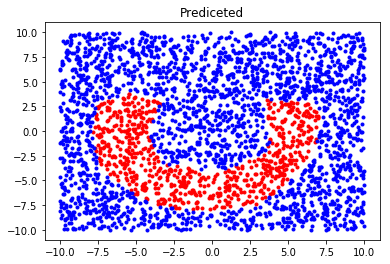

[7,   100] loss: 0.114


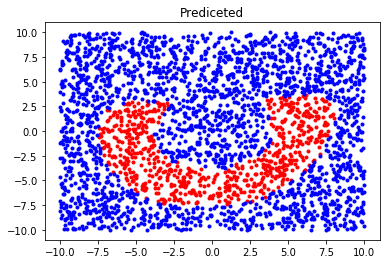

[7,   200] loss: 0.096


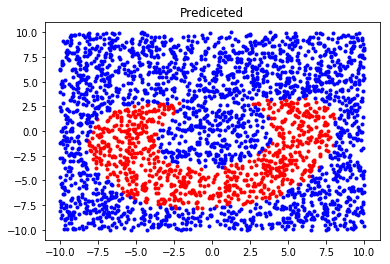

[7,   300] loss: 0.119


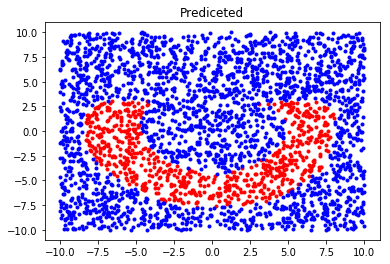

[8,   100] loss: 0.092


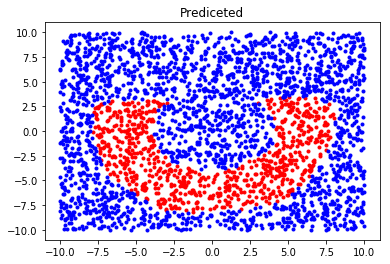

[8,   200] loss: 0.091


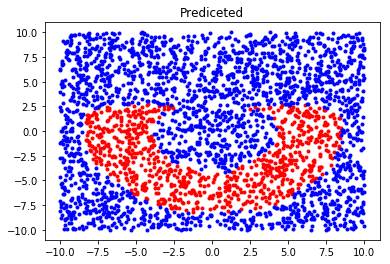

[8,   300] loss: 0.095


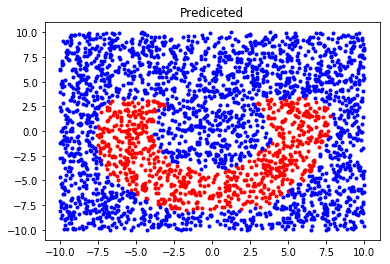

[9,   100] loss: 0.091


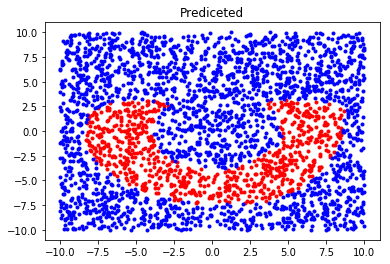

[9,   200] loss: 0.073


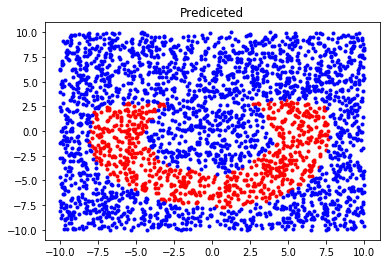

[9,   300] loss: 0.087


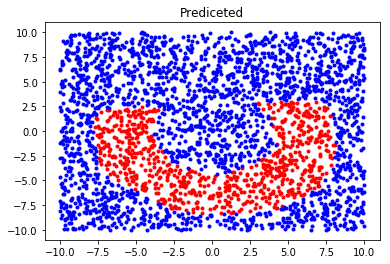

[10,   100] loss: 0.131


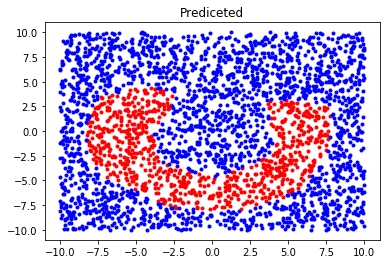

[10,   200] loss: 0.113


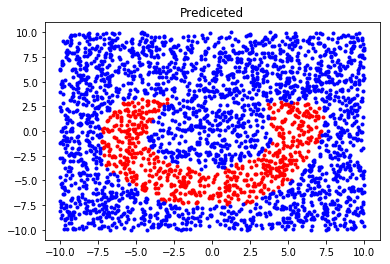

[10,   300] loss: 0.089


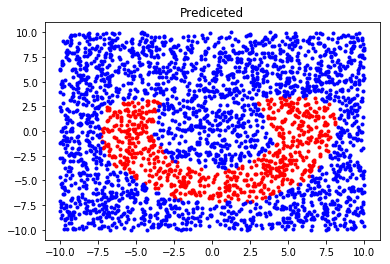

[11,   100] loss: 0.075


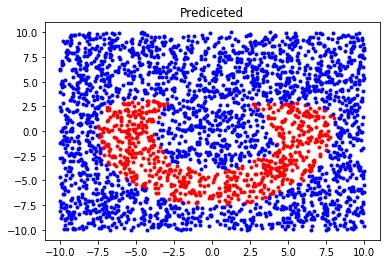

[11,   200] loss: 0.093


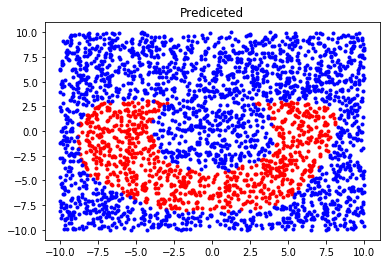

[11,   300] loss: 0.087


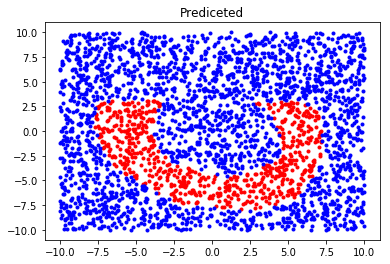

[12,   100] loss: 0.119


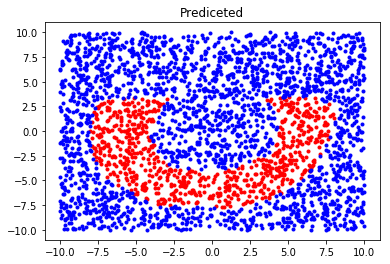

[12,   200] loss: 0.089


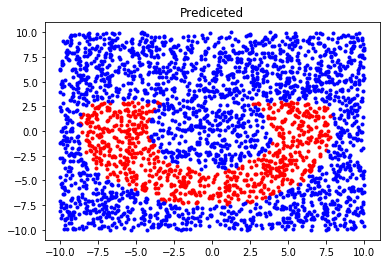

[12,   300] loss: 0.059


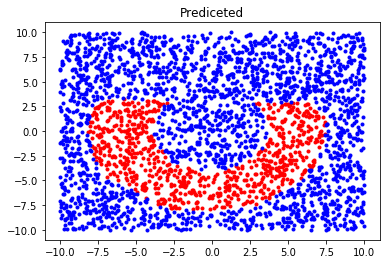

[13,   100] loss: 0.070


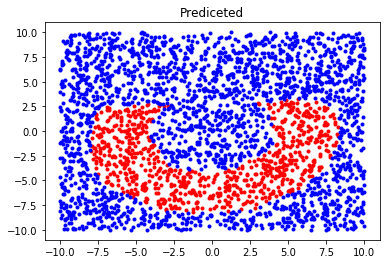

[13,   200] loss: 0.085


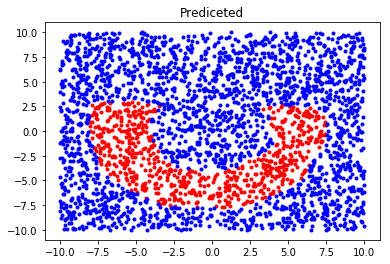

[13,   300] loss: 0.083


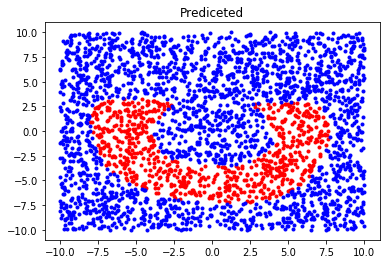

[14,   100] loss: 0.067


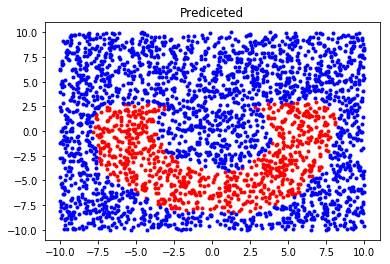

[14,   200] loss: 0.076


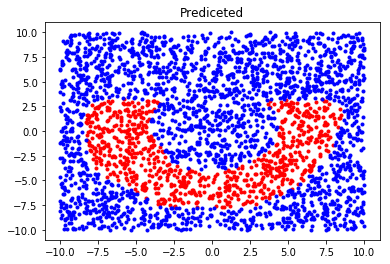

[14,   300] loss: 0.099


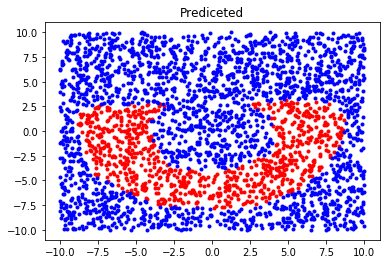

[15,   100] loss: 0.072


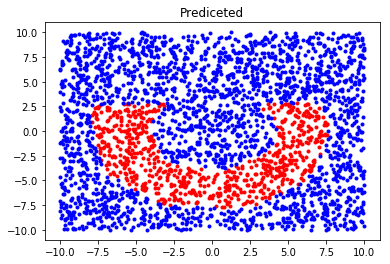

[15,   200] loss: 0.058


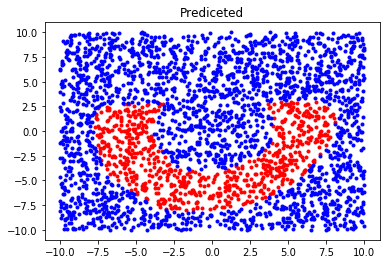

[15,   300] loss: 0.070


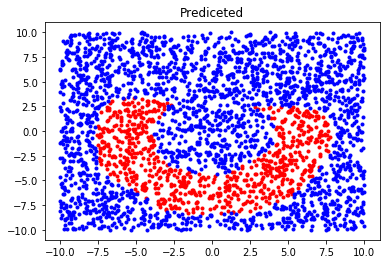

[16,   100] loss: 0.138


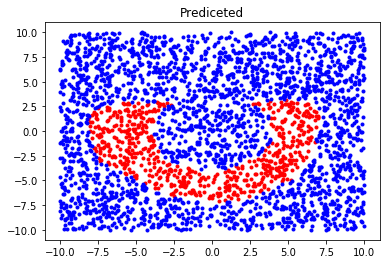

[16,   200] loss: 0.107


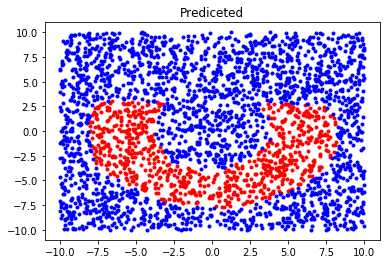

[16,   300] loss: 0.071


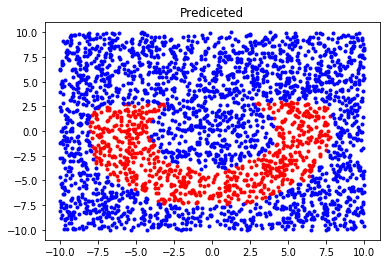

[17,   100] loss: 0.068


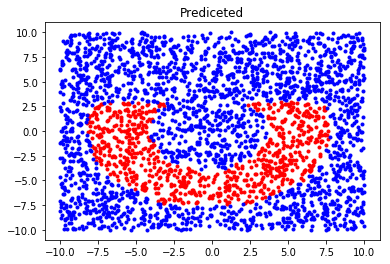

[17,   200] loss: 0.070


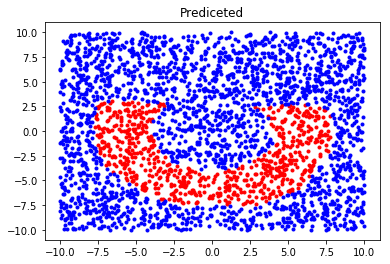

[17,   300] loss: 0.057


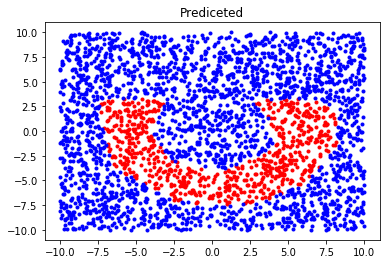

[18,   100] loss: 0.075


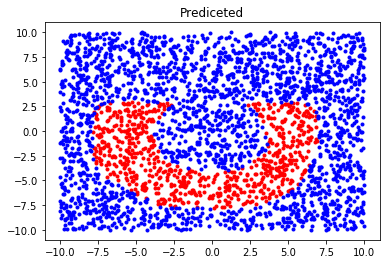

[18,   200] loss: 0.088


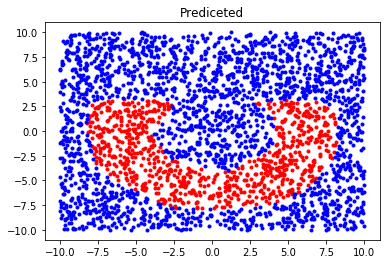

[18,   300] loss: 0.077


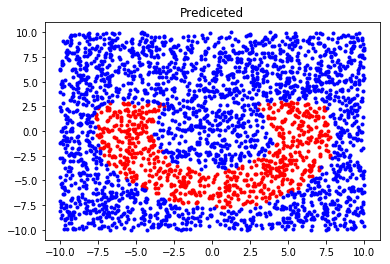

[19,   100] loss: 0.082


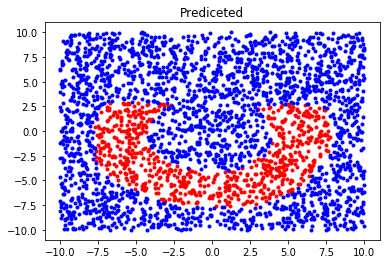

[19,   200] loss: 0.077


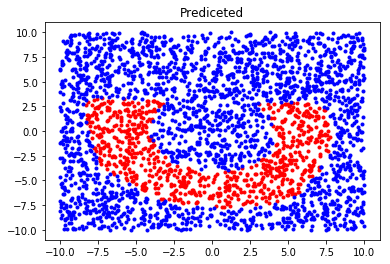

[19,   300] loss: 0.058


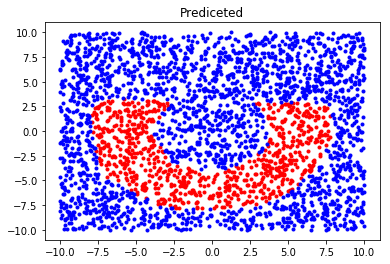

[20,   100] loss: 0.049


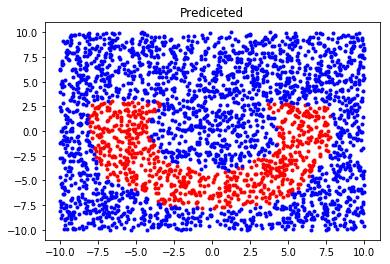

[20,   200] loss: 0.064


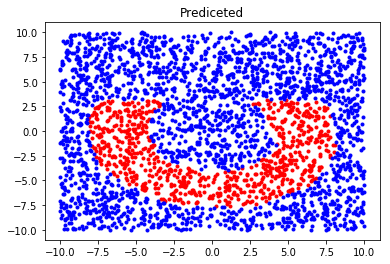

[20,   300] loss: 0.076


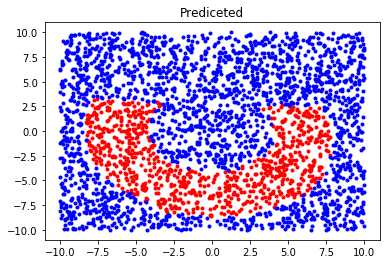

[21,   100] loss: 0.076


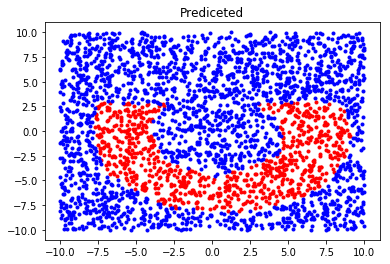

[21,   200] loss: 0.068


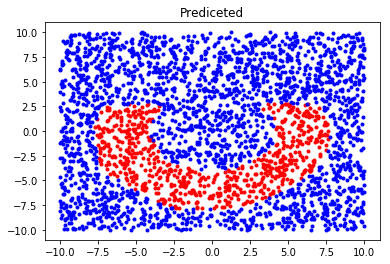

[21,   300] loss: 0.074


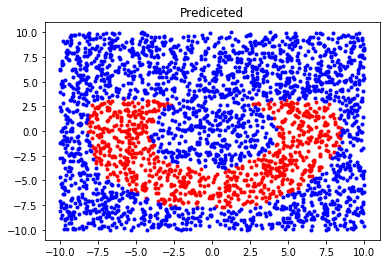

[22,   100] loss: 0.049


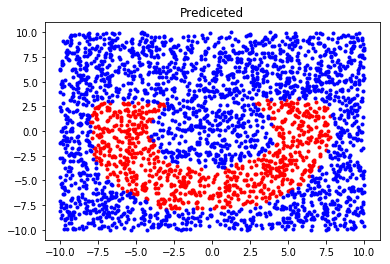

[22,   200] loss: 0.064


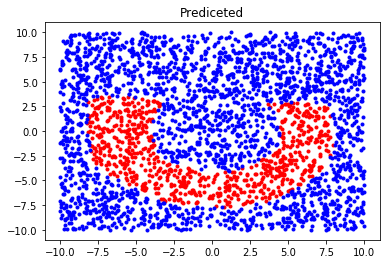

[22,   300] loss: 0.091


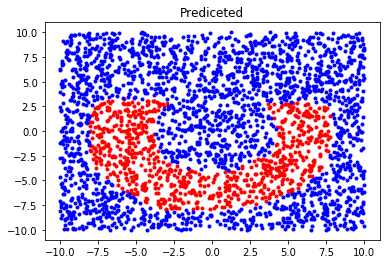

[23,   100] loss: 0.069


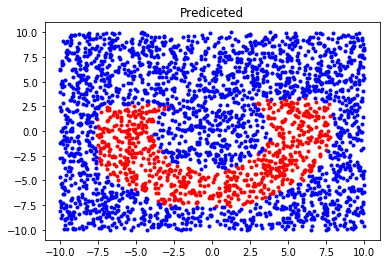

[23,   200] loss: 0.088


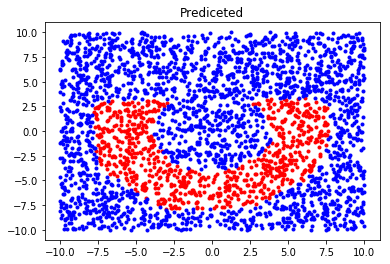

[23,   300] loss: 0.055


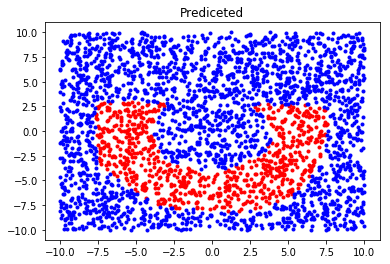

[24,   100] loss: 0.079


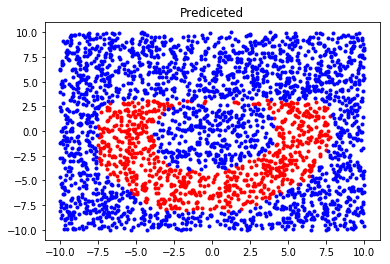

[24,   200] loss: 0.061


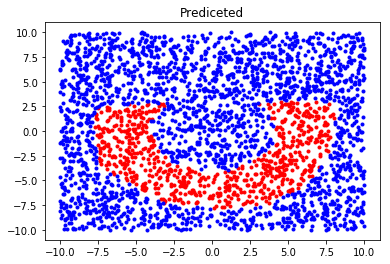

[24,   300] loss: 0.058


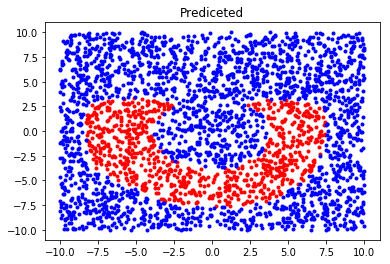

[25,   100] loss: 0.072


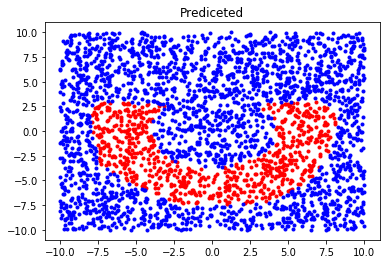

[25,   200] loss: 0.047


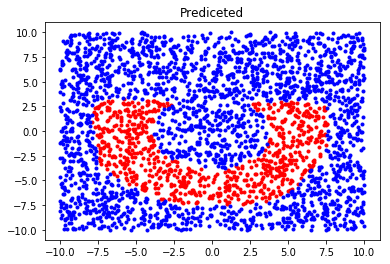

[25,   300] loss: 0.059


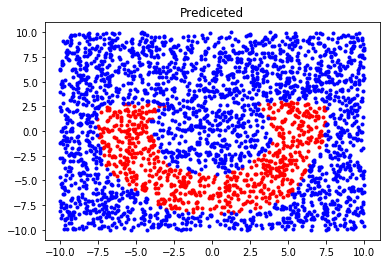

[26,   100] loss: 0.078


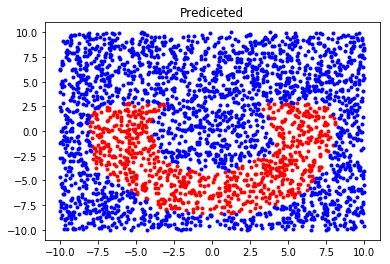

[26,   200] loss: 0.070


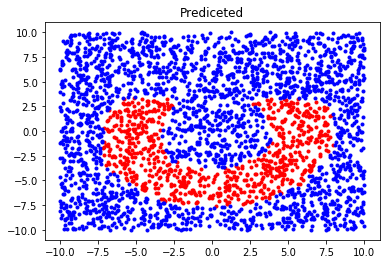

[26,   300] loss: 0.099


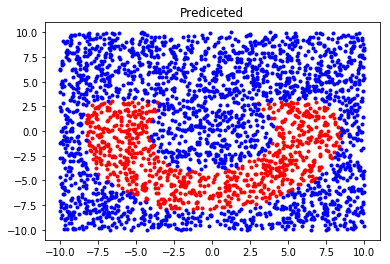

[27,   100] loss: 0.053


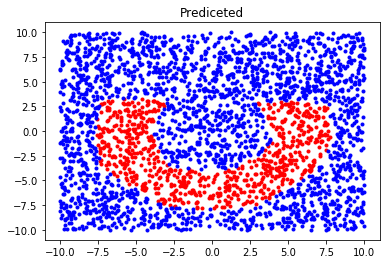

[27,   200] loss: 0.070


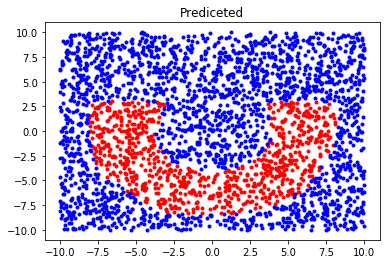

[27,   300] loss: 0.067


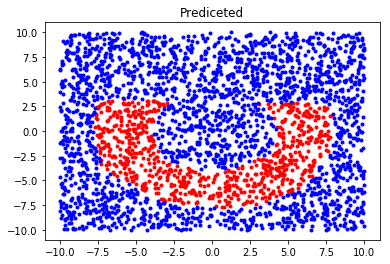

[28,   100] loss: 0.083


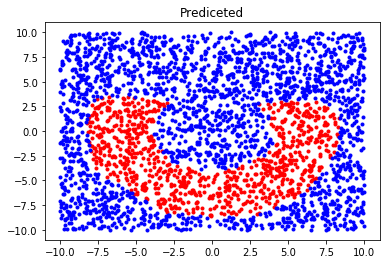

[28,   200] loss: 0.081


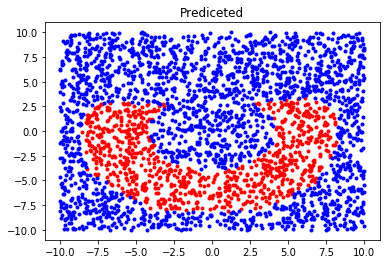

[28,   300] loss: 0.075


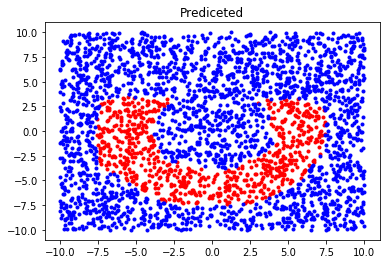

[29,   100] loss: 0.051


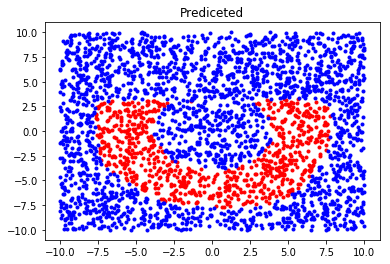

[29,   200] loss: 0.065


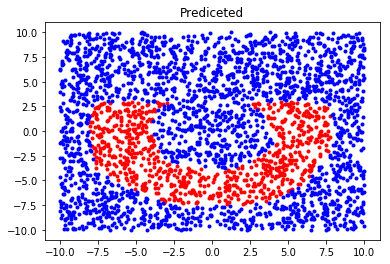

[29,   300] loss: 0.061


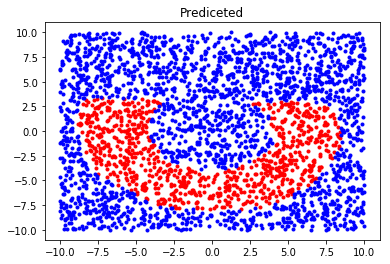

[30,   100] loss: 0.057


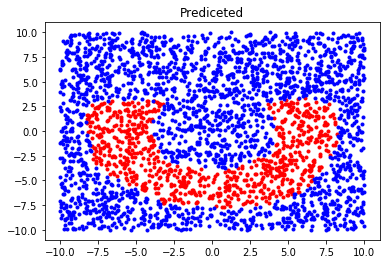

[30,   200] loss: 0.080


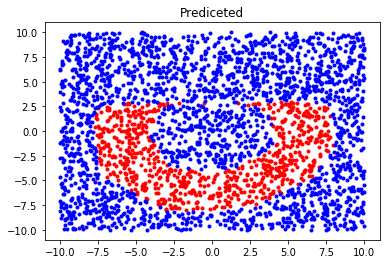

[30,   300] loss: 0.059


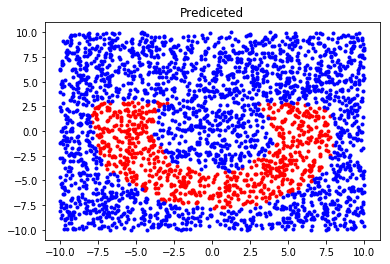

[31,   100] loss: 0.065


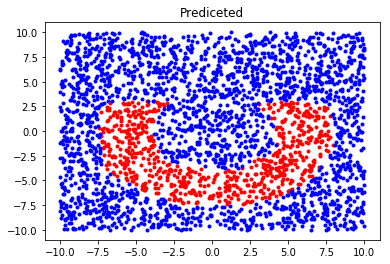

[31,   200] loss: 0.046


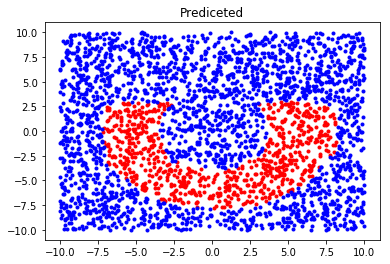

[31,   300] loss: 0.095


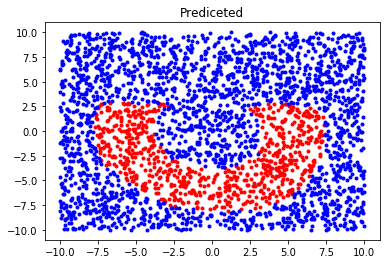

[32,   100] loss: 0.086


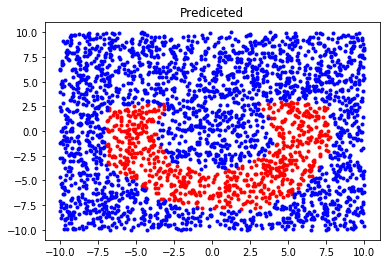

[32,   200] loss: 0.089


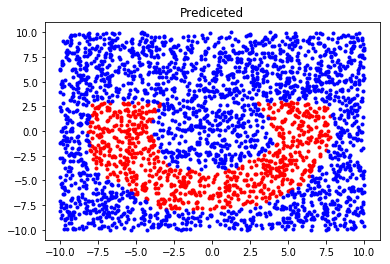

[32,   300] loss: 0.063


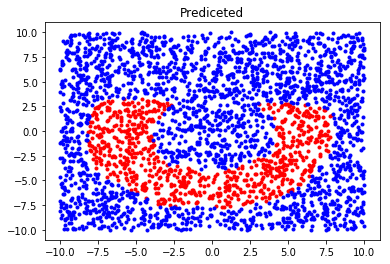

[33,   100] loss: 0.055


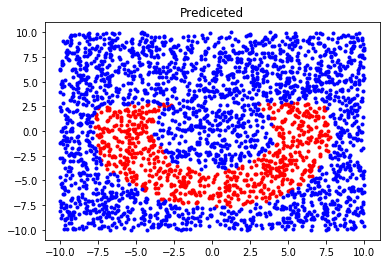

[33,   200] loss: 0.058


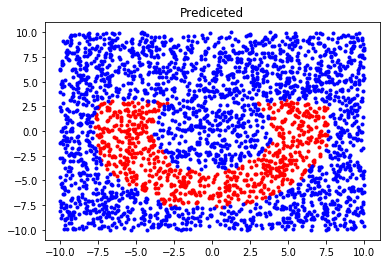

[33,   300] loss: 0.067


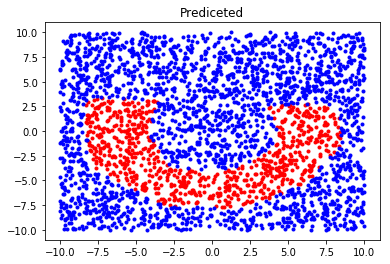

[34,   100] loss: 0.077


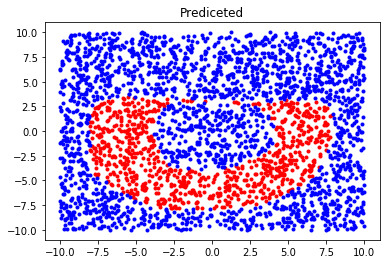

[34,   200] loss: 0.070


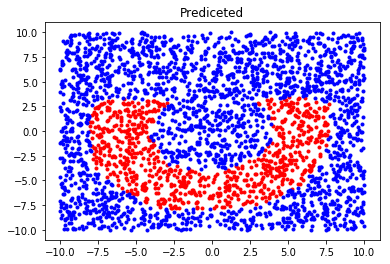

[34,   300] loss: 0.077


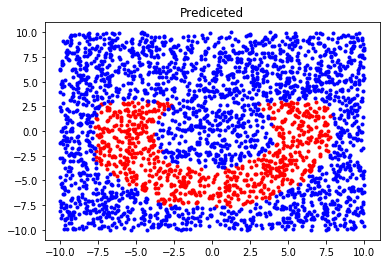

[35,   100] loss: 0.041


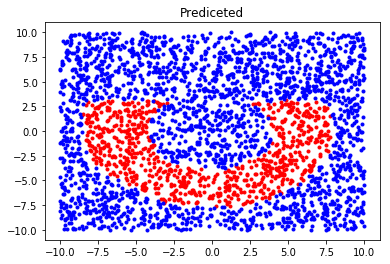

[35,   200] loss: 0.070


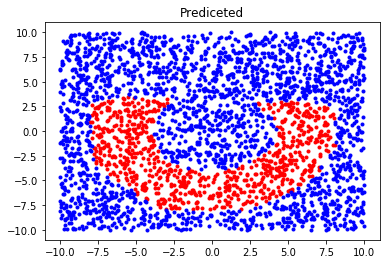

[35,   300] loss: 0.056


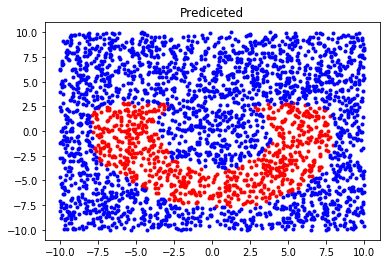

[36,   100] loss: 0.105


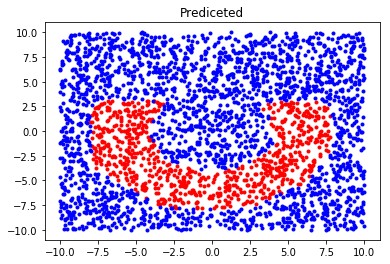

[36,   200] loss: 0.061


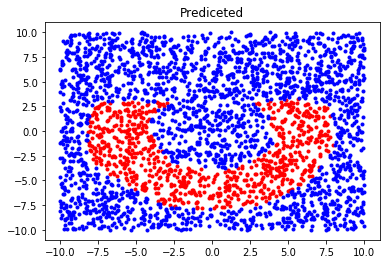

[36,   300] loss: 0.046


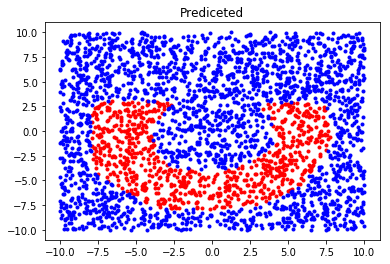

[37,   100] loss: 0.058


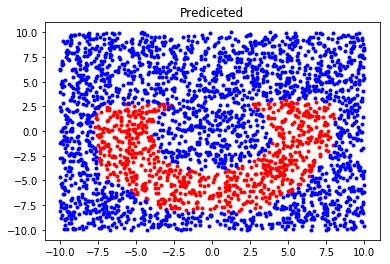

[37,   200] loss: 0.083


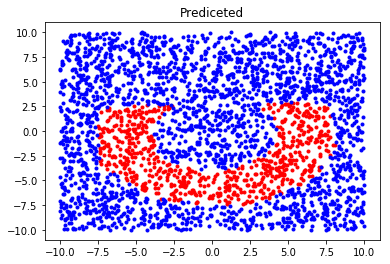

[37,   300] loss: 0.061


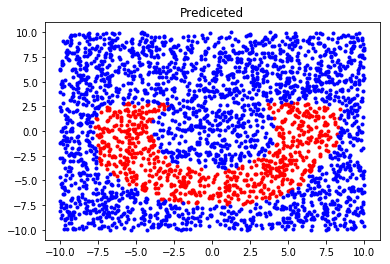

[38,   100] loss: 0.045


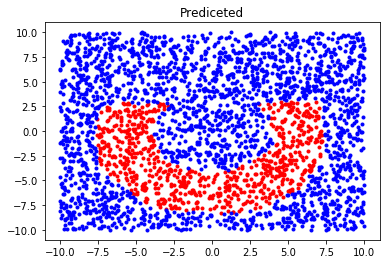

[38,   200] loss: 0.066


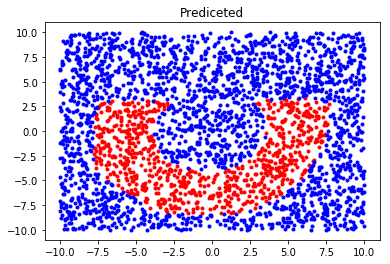

[38,   300] loss: 0.068


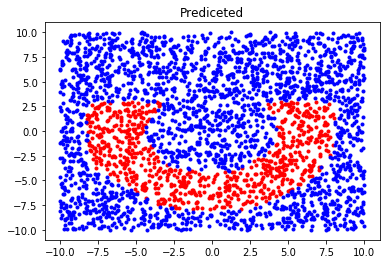

[39,   100] loss: 0.051


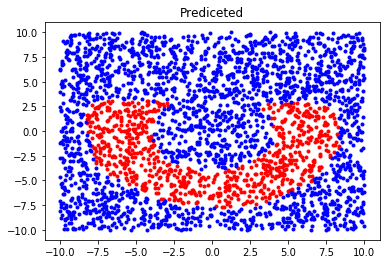

[39,   200] loss: 0.050


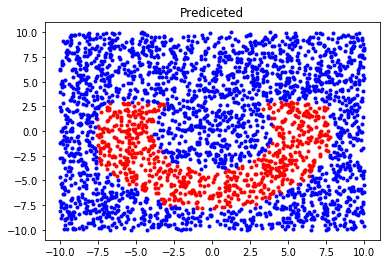

[39,   300] loss: 0.044


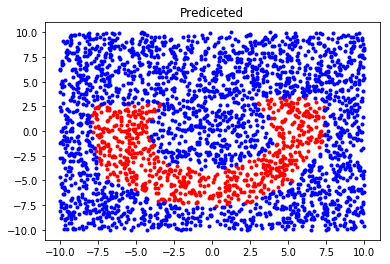

[40,   100] loss: 0.071


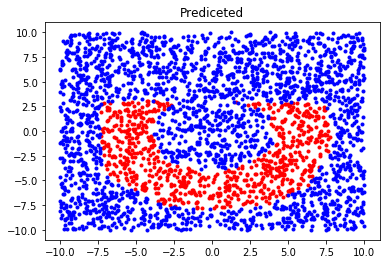

[40,   200] loss: 0.069


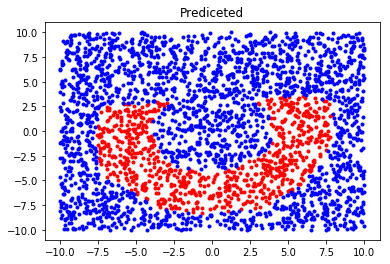

[40,   300] loss: 0.054


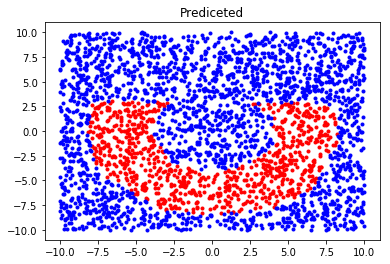

[41,   100] loss: 0.041


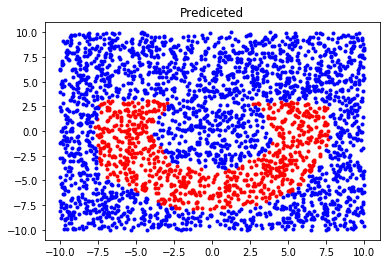

[41,   200] loss: 0.072


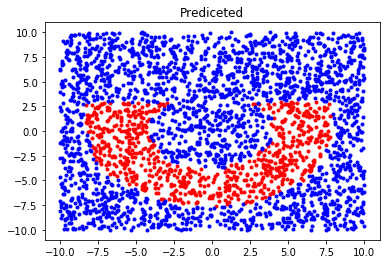

[41,   300] loss: 0.067


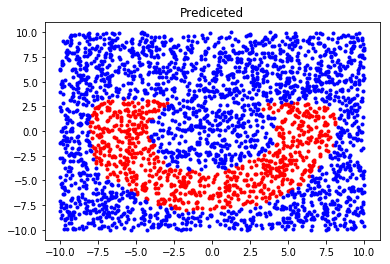

[42,   100] loss: 0.043


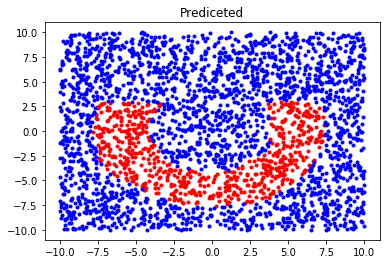

[42,   200] loss: 0.074


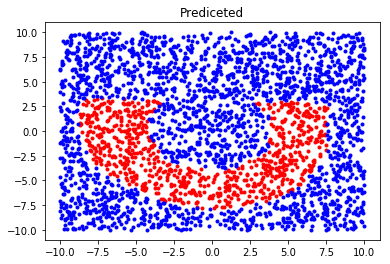

[42,   300] loss: 0.059


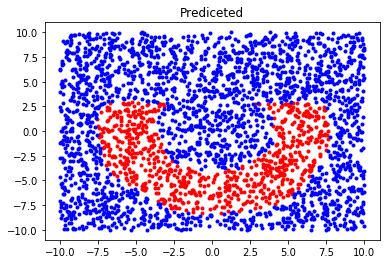

[43,   100] loss: 0.037


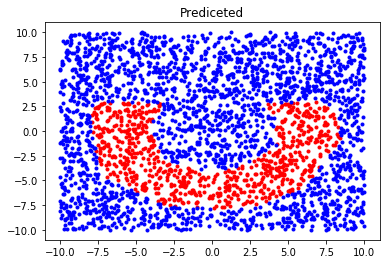

[43,   200] loss: 0.054


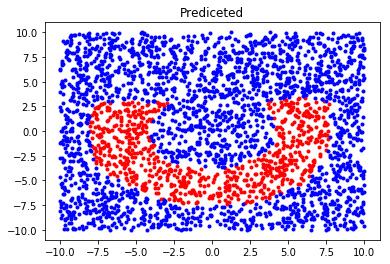

[43,   300] loss: 0.051


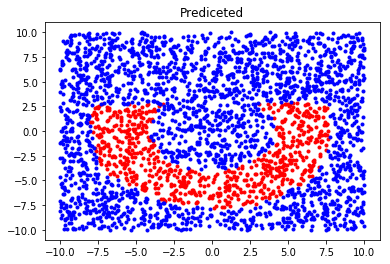

[44,   100] loss: 0.041


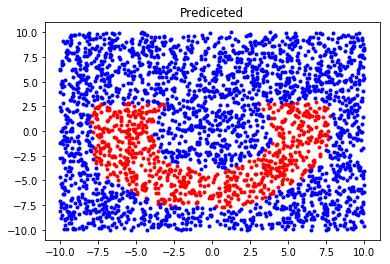

[44,   200] loss: 0.066


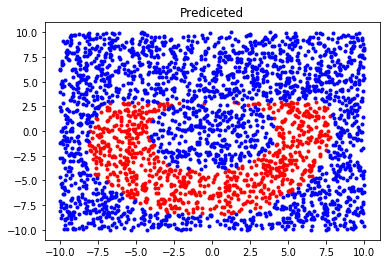

[44,   300] loss: 0.062


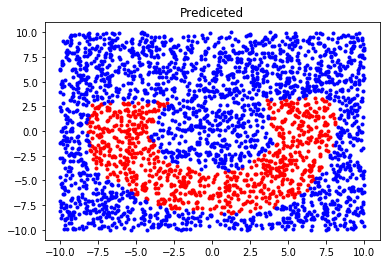

[45,   100] loss: 0.066


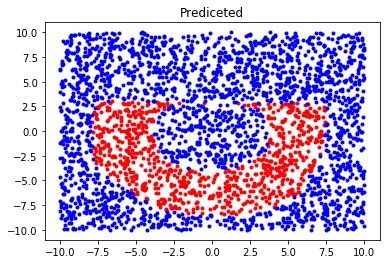

[45,   200] loss: 0.058


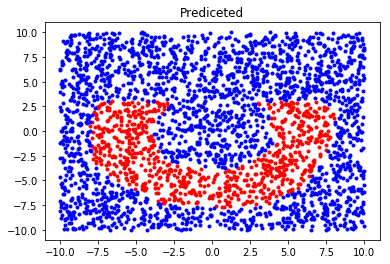

[45,   300] loss: 0.040


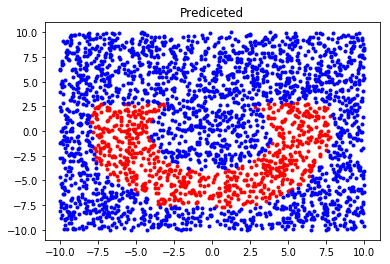

[46,   100] loss: 0.071


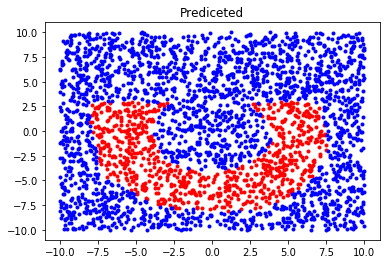

[46,   200] loss: 0.077


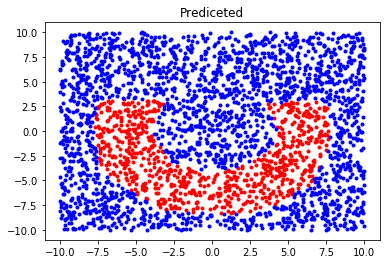

[46,   300] loss: 0.043


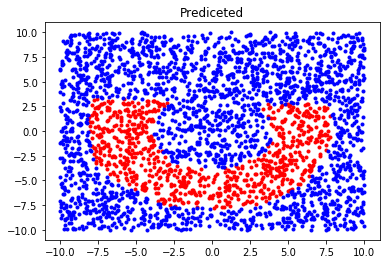

[47,   100] loss: 0.062


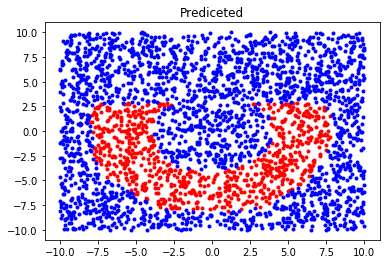

[47,   200] loss: 0.050


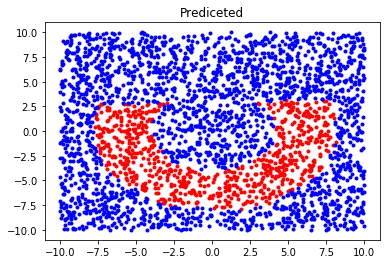

[47,   300] loss: 0.046


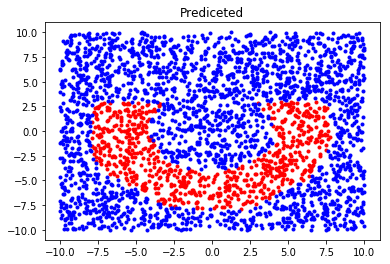

[48,   100] loss: 0.045


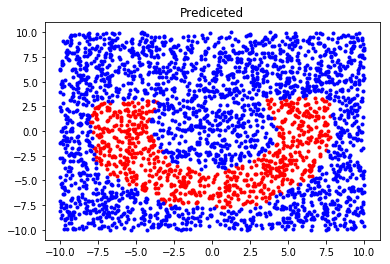

[48,   200] loss: 0.072


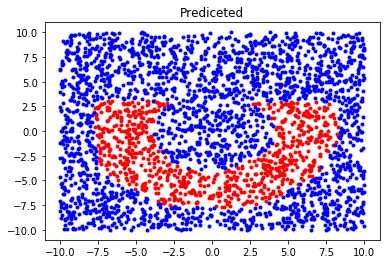

[48,   300] loss: 0.057


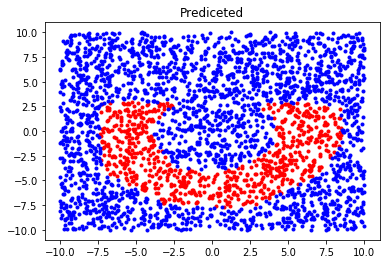

[49,   100] loss: 0.067


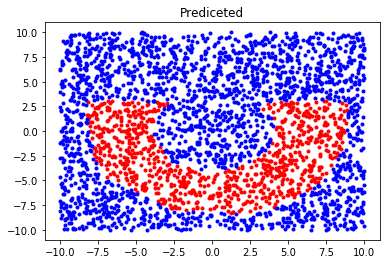

[49,   200] loss: 0.049


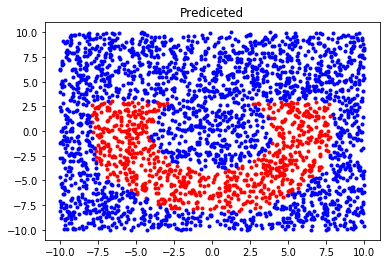

[49,   300] loss: 0.045


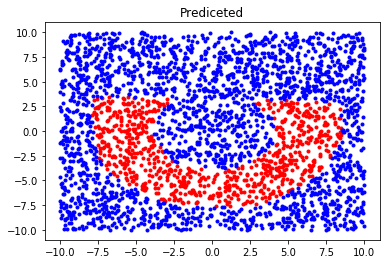

[50,   100] loss: 0.052


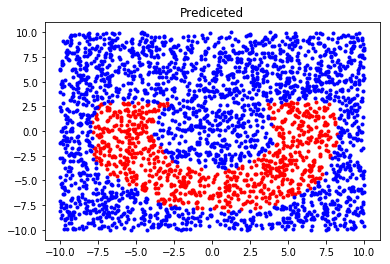

[50,   200] loss: 0.048


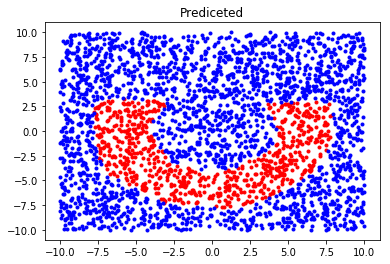

[50,   300] loss: 0.068


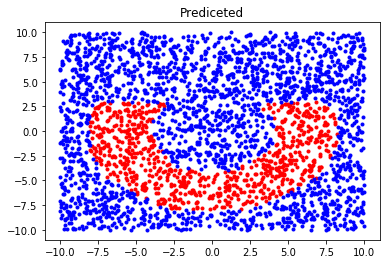

In [5]:
# Run training & testing
model = create_model()
dataset = CustomDataset(x_train, y_train)
fit(model, dataset, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=10e-3), 
    n_epochs=50, batch_size=10, verbose=True)

Accuracy of the network on the 3000 test data points: 98 %
Y_pred.shape =  (3000, 1)


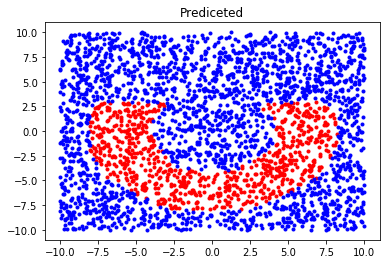

In [6]:
test(model, dataset)
Y_pred = np.expand_dims(predict_dataset(model, dataset), axis=1)
print("Y_pred.shape = ", Y_pred.shape)
plot_points_2d(X1, X2, Y_pred, "Prediceted")